# 5. Visualizing movement models in epymorph

epymorph expresses a model's movement dynamics as Movement Models: modular components which support rapid experimentation and comparison. To help visualize the differences between movements models, we can plot their concepts of movement probability between geographic nodes.

We'll use the same counties scope we created in part 3.

In [1]:
import numpy as np

from epymorph import *
from epymorph.adrio import commuting_flows, us_tiger
from epymorph.geography.us_census import STATE, CountyScope

# Create our scope: the counties in our four states.
scope = CountyScope.in_states_by_code(["AZ", "NM", "CO", "UT"], year=2020)

# We can extract the state fips codes from the county fips codes.
state_fips = {STATE.truncate(x) for x in scope.get_node_ids()}

# Find Maricopa County's index in the geo
MARICOPA_CO_IDX = np.where(scope.get_node_ids() == "04013")[0][0]

# We need a placeholder RUME to fetch data from ADRIOs...
rume = SingleStrataRume.build(
    # We're not going to use the RUME to run a simulation, so
    # the choice of IPM, MM, and Initializer are immaterial.
    ipm=ipm_library["no"](),
    mm=mm_library["no"](),
    init=init.NoInfection(),
    # But we do set our scope and "install" some ADRIOs
    # whose data we're interested in.
    scope=scope,
    params={
        "centroid": us_tiger.GeometricCentroid(),
        "commuters": commuting_flows.Commuters(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
)

## Centroids movement

Although a movement model normally encapsulates this detail, we'll "extract" its movement kernel here so we can map one row of it.

In [2]:
import numpy as np

from epymorph.data_type import CentroidDType
from epymorph.simulator.data import evaluate_param
from epymorph.util import pairwise_haversine, row_normalize

phi = 40.0
centroid = evaluate_param(rume, "centroid").astype(CentroidDType)
distance = pairwise_haversine(centroid["longitude"], centroid["latitude"])
centroids_kernel = np.log(row_normalize(1 / np.exp(distance / phi)))

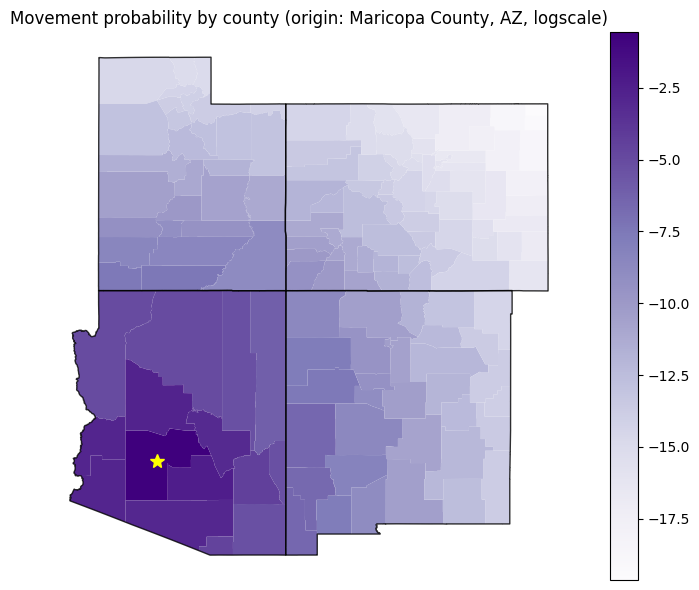

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

state_fips = tuple({STATE.truncate(x) for x in scope.get_node_ids()})
gdf_counties = us_tiger.get_counties_geo(scope.year)  # type:ignore
gdf_counties = gdf_counties[gdf_counties["GEOID"].str.startswith(state_fips)]

gdf_states = us_tiger.get_states_geo(scope.year)  # type:ignore
gdf_states = gdf_states[gdf_states["GEOID"].str.startswith(state_fips)]

gdf_merged = gdf_counties.merge(
    pd.DataFrame(
        {
            "GEOID": scope.get_node_ids(),
            "data": centroids_kernel[MARICOPA_CO_IDX],
        }
    ),
    on="GEOID",
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
gdf_merged.plot(ax=ax, column="data", cmap="Purples", legend=True)
gdf_states.plot(ax=ax, linewidth=1, edgecolor="black", color="none", alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = centroid[MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker="*", color="yellow", markersize=10)
fig.tight_layout()
plt.show()

## Commuters movement

We can do a similar treatment with the commuters movement model, where movement probability is based not on distance, but ACS Commuter Flows data at the county granularity.

In [4]:
import numpy as np

from epymorph.simulator.data import evaluate_param
from epymorph.util import row_normalize

# Commuters as a ratio to the total commuters living in that county.
commuters = evaluate_param(rume, "commuters").astype(np.int64)
pei_kernel = np.log(row_normalize(commuters) + 0.0000000001)

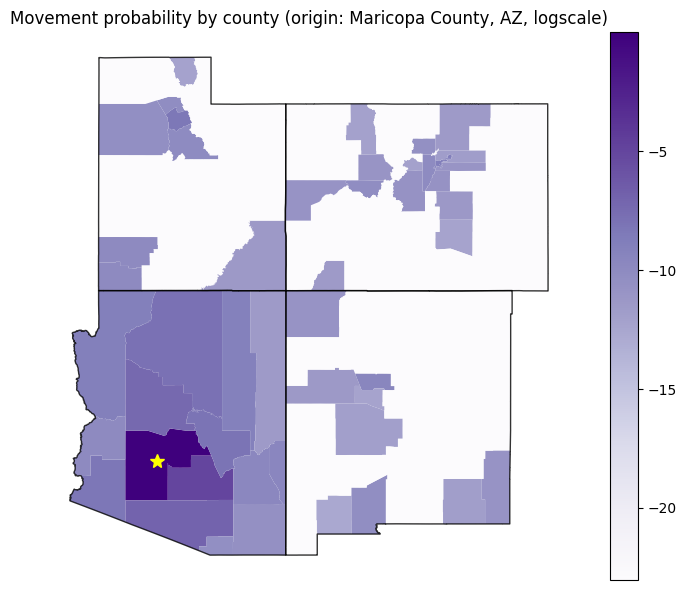

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

state_fips = tuple({STATE.truncate(x) for x in scope.get_node_ids()})
gdf_counties = us_tiger.get_counties_geo(scope.year)  # type:ignore
gdf_counties = gdf_counties[gdf_counties["GEOID"].str.startswith(state_fips)]

gdf_states = us_tiger.get_states_geo(scope.year)  # type:ignore
gdf_states = gdf_states[gdf_states["GEOID"].str.startswith(state_fips)]

gdf_merged = gdf_counties.merge(
    pd.DataFrame(
        {
            "GEOID": scope.get_node_ids(),
            "data": pei_kernel[MARICOPA_CO_IDX],
        }
    ),
    on="GEOID",
)


fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
ax.set_title("Movement probability by county (origin: Maricopa County, AZ, logscale)")
gdf_merged.plot(ax=ax, column="data", cmap="Purples", legend=True)
gdf_states.plot(ax=ax, linewidth=1, edgecolor="black", color="none", alpha=0.8)
# Get Maricopa County's centroid from the geo so we can mark it.
origin = centroid[MARICOPA_CO_IDX]
ax.plot(origin[0], origin[1], marker="*", color="yellow", markersize=10)
fig.tight_layout()
plt.show()